In [1]:
from metasyn import MetaFrame
import time
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from tqdm import tqdm
import datetime as dt
from faker import Faker
from metasyn.distribution import FreeTextDistribution
from metasyn.provider import BuiltinDistributionProvider
DEFAULT_NCOL = 30

In [2]:
def int_generator(size):
    for _ in range(DEFAULT_NCOL):
        yield pl.Series(np.random.randint(0, 1000, size=size))

In [3]:
def float_generator(size):
    for _ in range(DEFAULT_NCOL):
        yield pl.Series(np.random.rand(size))

In [4]:
def cat_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series(np.random.choice(["category1", "othercat", "whatinthename"], size=size), dtype=pl.Categorical)

In [5]:
def date_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series([dt.date(1954, 1, x) for x in np.random.randint(1, 32, size=size)])
    

In [6]:
def time_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series([dt.time(x, 12, 13) for x in np.random.randint(0, 24, size=size)])

In [7]:
def datetime_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series([dt.datetime(x, 10, 14) for x in np.random.randint(1956, 2021, size=size)])

In [8]:
def string_generator(size):
    fake = Faker()
    # Faker.seed(12345)
    faker_types = ["address", "phone_number", "pricetag", "timezone", "mime_type", "unix_partition",
                   "ascii_email", "isbn10", "job", "ssn", "user_agent", "color", "license_plate",
                   "iban", "company", "time", "ipv4", "uri", "name", "sentence"]
    series_dict = {}
    
    for ftype in faker_types:
        series = pl.Series([getattr(fake, ftype)() for _ in range(size)])
        yield series
    yield pl.Series([fake.paragraph(nb_sentences=5) for _ in range(size)])

In [9]:
TYPE_GEN_DICT = {
    "discrete": int_generator,
    "continuous": float_generator,
    "categorical": cat_generator,
    "date": date_generator,
    "time": time_generator,
    "datetime": datetime_generator,
    "string": string_generator,
}

In [10]:
def benchmark_dist(distribution, df_generator, size):
    bench_times = []
    for series in df_generator(size):
        start_time = time.time()
        distribution.fit(series)
        bench_times.append(time.time()-start_time)
    return bench_times

In [11]:
def fit(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

In [34]:
def benchmark(plot=False):
    provider = BuiltinDistributionProvider()
    for var_type in provider.all_var_types:
        if var_type == "string":
            max_size = 30000
        else:
            max_size = 100000
        print(f"------------- {var_type} -------------")
        for dist in provider.get_dist_list(var_type):
            # Warm up FreeTextDistribution
            if issubclass(dist, FreeTextDistribution):
                for _ in range(3):
                    benchmark_dist(dist, TYPE_GEN_DICT["string"], max_size)
            all_sizes = np.linspace(1, max_size, 20).astype(int)
            fit_times = []
            for size in all_sizes:
                fit_times.append(np.mean(benchmark_dist(dist, TYPE_GEN_DICT[var_type], size)))
            a_fit, b_fit = fit(all_sizes, fit_times)
            if plot:
                plt.plot(all_sizes, fit_times)
                plt.plot(all_sizes, a_fit*all_sizes+b_fit, label=f"{a_fit:.3e} * x + {b_fit:.3e}")
                plt.title(dist.implements)
                plt.xlabel("len(series)")
                plt.ylabel("t(s)")
                plt.legend()
                plt.show()
            print(dist.implements, a_fit, b_fit)

------------- discrete -------------


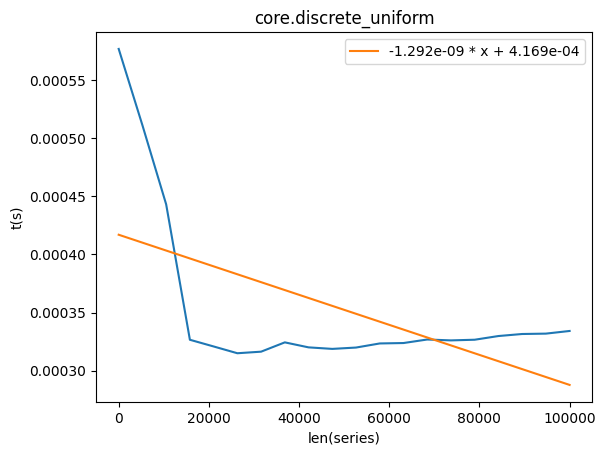

core.discrete_uniform -1.2921892435943624e-09 0.00041691231647729063


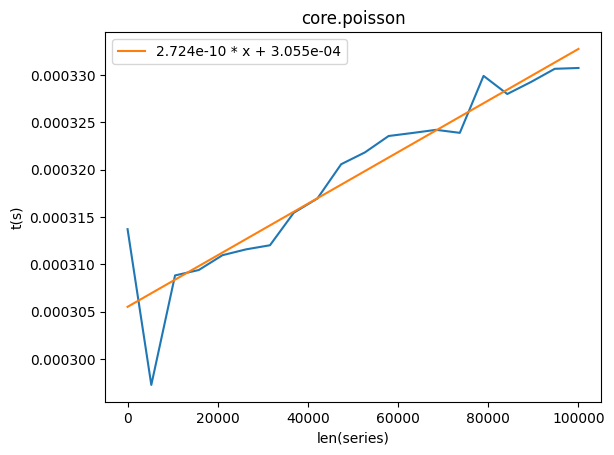

core.poisson 2.7239340925495157e-10 0.00030549961040203825


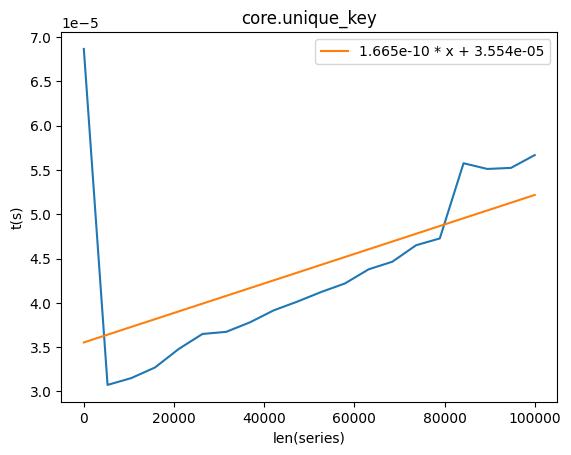

core.unique_key 1.6651654243801237e-10 3.5536030549586725e-05


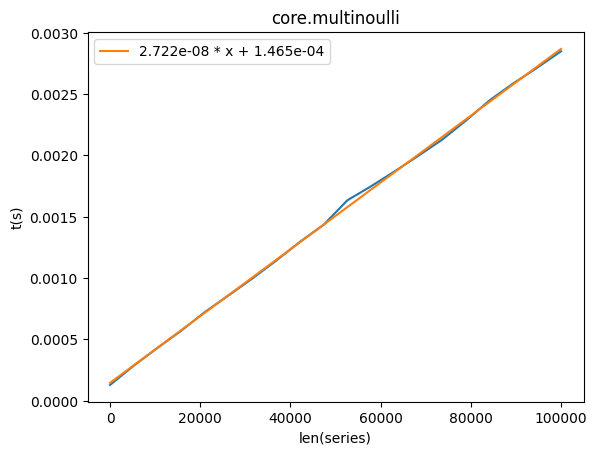

core.multinoulli 2.7222395470745215e-08 0.00014648219277623394
------------- categorical -------------


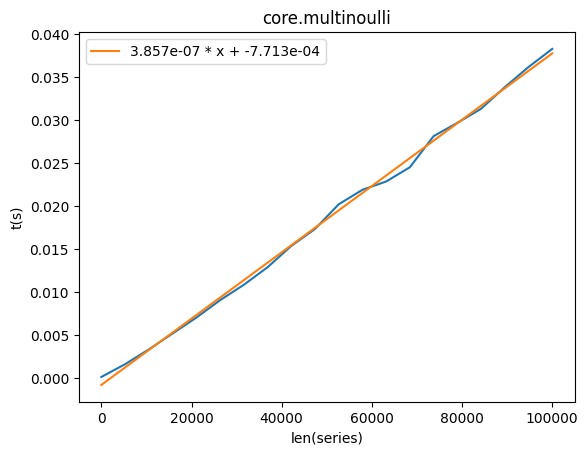

core.multinoulli 3.8566756869698255e-07 -0.0007713382680780222
------------- string -------------


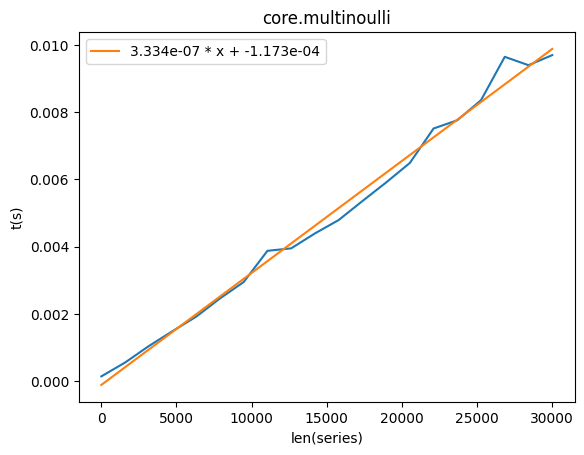

core.multinoulli 3.334255921149247e-07 -0.0001173261375240872


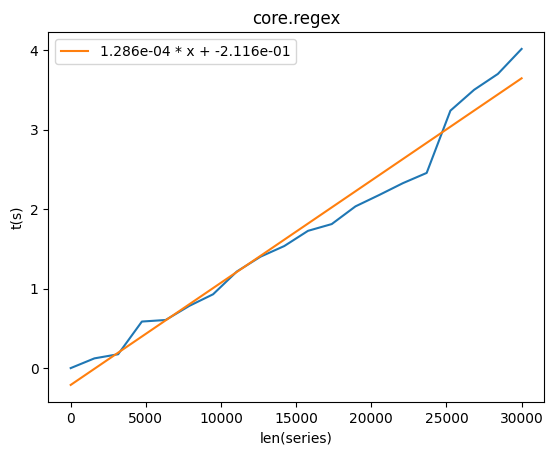

core.regex 0.0001285967707091924 -0.21156885193678848


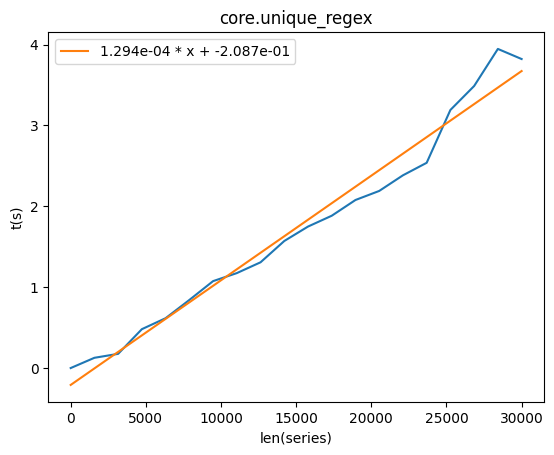

core.unique_regex 0.00012939061605020416 -0.20867782495402717


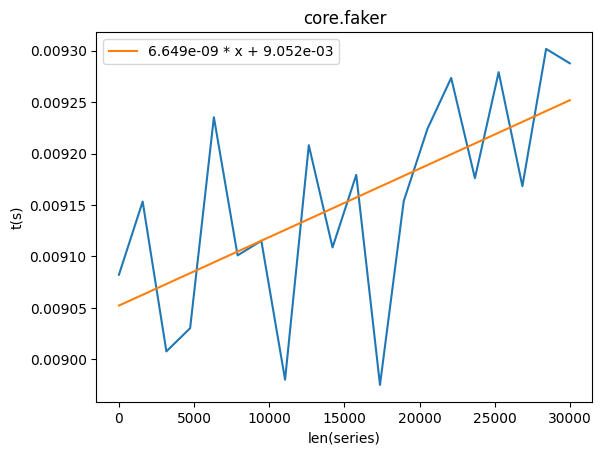

core.faker 6.649267414384807e-09 0.009052290465818506


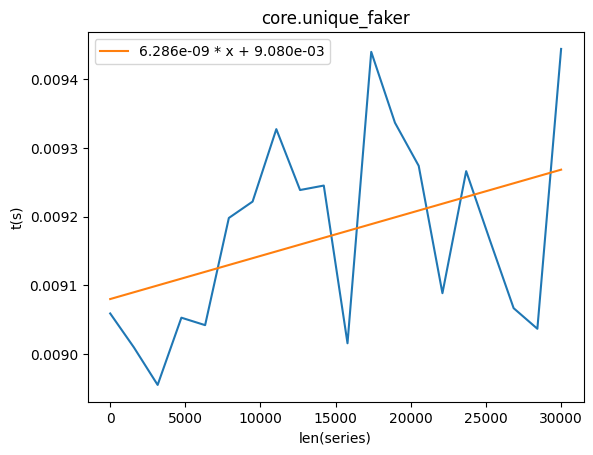

core.unique_faker 6.286045600692698e-09 0.009079851566733367
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/qubix/.pyenv/versions/3.11.1/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_84382/2982160846.py", line 1, in <module>
    benchmark(plot=True)
  File "/tmp/ipykernel_84382/1240152102.py", line 17, in benchmark
    fit_times.append(np.mean(benchmark_dist(dist, TYPE_GEN_DICT[var_type], size)))
                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_84382/3544738180.py", line 5, in benchmark_dist
    distribution.fit(series)
  File "/home/qubix/Documents/shared_work/synthetic/metasyn/metasyn/distribution/base.py", line 46, in fit
    return cls._fit(pd_series, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/qubix/Documents/shared_work/synthetic/metasyn/metasyn/distribution/faker.py", line 99, in _fit
  File "/home/qubix/Documents/shared_work/synthe

In [35]:
benchmark(plot=True)

In [22]:
from metasyn.distribution import FreeTextDistribution, RegexDistribution

def free_bench():
    free_times = []
    free_lengths = []
    for series in string_generator(100):
        start = time.time()
        # FreeTextDistribution.fit(series)
        RegexDistribution.fit(series)
        free_times.append(time.time()-start)
        free_lengths.append(series.str.lengths().mean())
    return np.array(free_lengths), np.array(free_times)


In [23]:
def fit_a(x, y):
    A = np.vstack([x]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

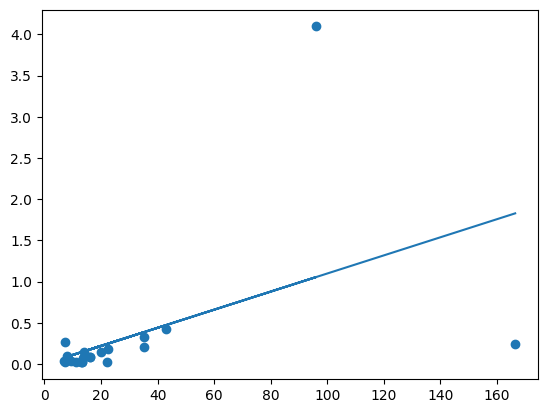

In [26]:
lengths_first, times_first = free_bench()
# lengths_second, times_second = free_bench()
a = fit_a(lengths_first, times_first)[0]
plt.scatter(lengths_first, times_first)
plt.plot(lengths_first, a*lengths_first)
plt.show()

In [28]:
print(a, np.mean(lengths_first))

0.010984301403397095 28.068095238095236


In [31]:
series = pl.Series(["1", "2", None])

In [33]:
series.drop_nulls().str.lengths().mean()

1.0